In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


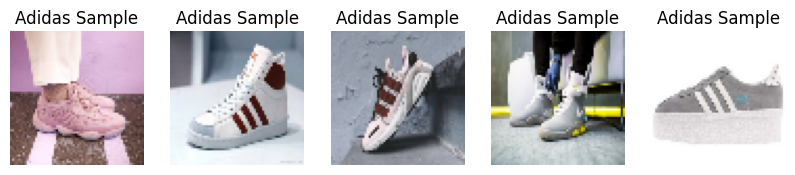

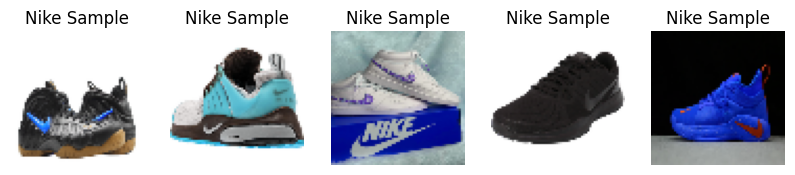

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 323ms/step - loss: 0.6921 - val_loss: 0.6860
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 285ms/step - loss: 0.6578 - val_loss: 0.7219
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 273ms/step - loss: 0.6345 - val_loss: 0.6675
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 460ms/step - loss: 0.6201 - val_loss: 0.6785
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 290ms/step - loss: 0.6030 - val_loss: 0.6531
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 359ms/step - loss: 0.5704 - val_loss: 0.6135
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 267ms/step - loss: 0.5547 - val_loss: 0.6105
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 372ms/step - loss: 0.5427 - val_loss: 0.5929
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 418ms/step - loss: 0.5368 - val_loss: 0.5857
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 253ms/step - loss: 0.5443 - val_loss: 0.5781
Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 273ms/step - loss: 0.4976 - val_loss: 0.4102
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 279ms/step - loss: 0.4986 - val_loss

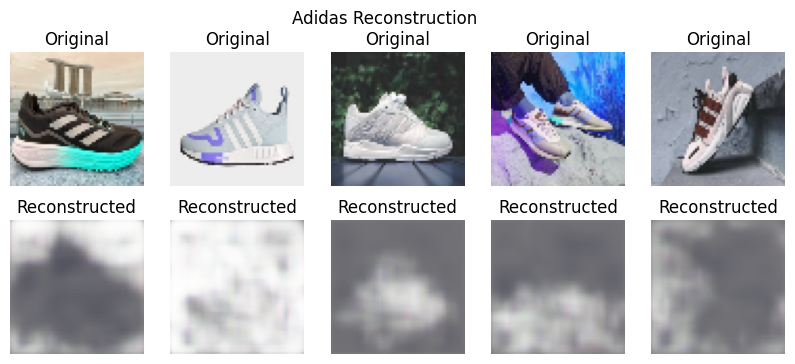

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


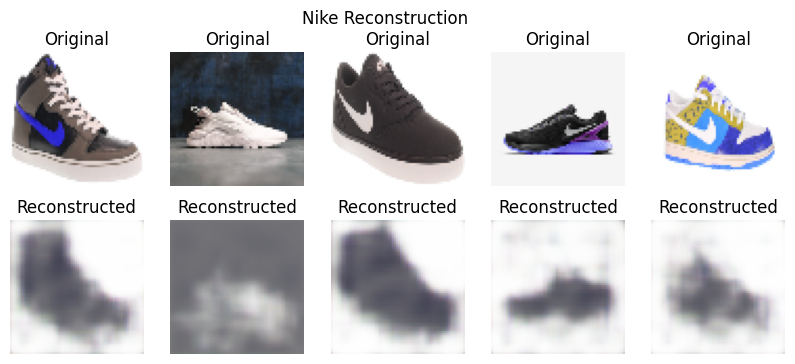

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Function to load shoe image dataset
def load_dataset(folder_path):
    images = []
    labels = []
    for label, class_name in enumerate(['adidas', 'nike']):
        class_folder = os.path.join(folder_path, class_name)
        for image_name in os.listdir(class_folder):
            image_path = os.path.join(class_folder, image_name)
            image = cv2.imread(image_path)
            image = cv2.resize(image, (64, 64))  # Resize images to 64x64
            images.append(image)
            labels.append(label)
    return np.array(images), np.array(labels)

# Load shoe image dataset
x_train, y_train = load_dataset('/content/drive/MyDrive/Manajemen Proyek/archive (1)/train')  # Replace with the path to the train dataset folder
x_test, y_test = load_dataset('/content/drive/MyDrive/Manajemen Proyek/archive (1)/test')     # Replace with the path to the test dataset folder

# Normalize pixel values to the range [0, 1]
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Split test data for each class
x_test_adidas = x_test[y_test == 0]
x_test_nike = x_test[y_test == 1]

# Function to display sample images
def show_samples(images, title):
    plt.figure(figsize=(10, 2))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(images[i])
        plt.title(title)
        plt.axis('off')
    plt.show()

# Display 5 sample images for each class
show_samples(x_train[y_train == 0], "Adidas Sample")
show_samples(x_train[y_train == 1], "Nike Sample")

# Define Autoencoder model
input_shape = (64, 64, 3)
latent_dim = 64

autoencoder = tf.keras.models.Sequential([
    # Encoder
    tf.keras.layers.Input(shape=input_shape),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
    tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), padding='same'),

    # Latent space
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(latent_dim, activation='relu'),

    # Decoder
    tf.keras.layers.Dense(8*8*8, activation='relu'),
    tf.keras.layers.Reshape((8, 8, 8)),
    tf.keras.layers.Conv2DTranspose(8, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.UpSampling2D((2, 2)),
    tf.keras.layers.Conv2DTranspose(16, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.UpSampling2D((2, 2)),
    tf.keras.layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.UpSampling2D((2, 2)),
    tf.keras.layers.Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')
])

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train the model with 'Adidas' data
autoencoder.fit(x_train[y_train == 0], x_train[y_train == 0],
                epochs=10,
                batch_size=32,
                shuffle=True,
                validation_data=(x_test_adidas, x_test_adidas))

# Train the model with 'Nike' data
autoencoder.fit(x_train[y_train == 1], x_train[y_train == 1],
                epochs=10,
                batch_size=32,
                shuffle=True,
                validation_data=(x_test_nike, x_test_nike))

# Function to display test images and their reconstructions
def show_reconstructions(images, reconstructed_images, title):
    plt.figure(figsize=(10, 4))
    for i in range(5):
        plt.subplot(2, 5, i+1)
        plt.imshow(images[i])
        plt.title("Original")
        plt.axis('off')

        plt.subplot(2, 5, i+6)
        plt.imshow(reconstructed_images[i])
        plt.title("Reconstructed")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Reconstruct 'Adidas' images and display them
reconstructed_adidas = autoencoder.predict(x_test_adidas)
show_reconstructions(x_test_adidas, reconstructed_adidas, "Adidas Reconstruction")

# Reconstruct 'Nike' images and display them
reconstructed_nike = autoencoder.predict(x_test_nike)
show_reconstructions(x_test_nike, reconstructed_nike, "Nike Reconstruction")


In [4]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import os
import numpy as np

# Fungsi untuk memuat dataset citra dari folder
def load_images_from_folder(folder, target_size=(100, 100)):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = load_img(img_path, target_size=target_size)
        img_array = img_to_array(img)
        images.append(img_array)
        labels.append(folder.split('/')[-1])  # Menggunakan nama folder sebagai label
    return images, labels

# Path ke folder 'Nike' dan 'Adidas'
nike_folder = '/content/drive/MyDrive/Manajemen Proyek/archive (1)/test/nike'
adidas_folder = '/content/drive/MyDrive/Manajemen Proyek/archive (1)/test/adidas'

# Memuat citra dan label dari folder 'Nike'
nike_images, nike_labels = load_images_from_folder(nike_folder, target_size=(100, 100))

# Memuat citra dan label dari folder 'Adidas'
adidas_images, adidas_labels = load_images_from_folder(adidas_folder, target_size=(100, 100))

# Menggabungkan citra dan label dari kedua kelas
x_data = np.array(nike_images + adidas_images)
y_labels = np.array(nike_labels + adidas_labels)

# Menggunakan LabelEncoder untuk mengonversi nama kelas menjadi nilai numerik
label_encoder = LabelEncoder()
y_labels_encoded = label_encoder.fit_transform(y_labels)

# Konversi label menjadi one-hot encoding
y_one_hot = to_categorical(y_labels_encoded)

# Memecah dataset menjadi data latih dan data uji
x_train, x_test, y_train, y_test = train_test_split(x_data, y_one_hot, test_size=0.2, random_state=42)

# Normalisasi citra
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(48, 100, 100, 3)
(12, 100, 100, 3)
(48, 2)
(12, 2)


In [5]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Reshape
from sklearn.model_selection import train_test_split

# Fungsi untuk memuat dataset citra dari folder
def load_images_from_folder(folder):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = load_img(img_path, target_size=(100, 100, 3))  # Sesuaikan dengan ukuran citra dan saluran warna yang diinginkan
        img_array = img_to_array(img)
        images.append(img_array)
        labels.append(folder.split('/')[-1])  # Menggunakan nama folder sebagai label
    return images, labels

# Path ke folder 'nike' dan 'adidas'
nike_folder = '/content/drive/MyDrive/Manajemen Proyek/archive (1)/train/nike'
adidas_folder = '/content/drive/MyDrive/Manajemen Proyek/archive (1)/train/adidas'

# Memuat citra dan label dari folder 'asian'
nike_images, nike_labels = load_images_from_folder(nike_folder)

# Memuat citra dan label dari folder 'african'
adidas_images, adidas_labels = load_images_from_folder(adidas_folder)

# Menggabungkan citra dan label dari kedua kelas
x_data = np.array(nike_images + adidas_images)
y_labels = np.array(nike_labels + adidas_labels)

# Konversi label menjadi one-hot encoding
label_encoder = LabelEncoder()
y_labels_encoded = label_encoder.fit_transform(y_labels)
y_one_hot = to_categorical(y_labels_encoded)

# Memecah dataset menjadi data latih dan data uji
x_train, x_test, y_train, y_test = train_test_split(x_data, y_one_hot, test_size=0.2, random_state=42)

# Normalisasi citra
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Model autoencoder
input_shape = (100, 100, 3)  # Sesuaikan dengan ukuran dan saluran warna citra yang diinginkan
encoded_dim = 64

# Encoder
encoder_input = Input(shape=input_shape)
flat = Flatten()(encoder_input)
encoded = Dense(encoded_dim, activation='relu')(flat)

# Decoder
decoder_input = Input(shape=(encoded_dim,))
flat_decoded = Dense(np.prod(input_shape), activation='sigmoid')(decoder_input)
decoded = Reshape(input_shape)(flat_decoded)

# Model
encoder = Model(encoder_input, encoded, name='encoder')
decoder = Model(decoder_input, decoded, name='decoder')
autoencoder_input = Input(shape=input_shape)
autoencoder = Model(autoencoder_input, decoder(encoder(autoencoder_input)), name='autoencoder')

# Kompilasi model
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Pelatihan model
autoencoder.fit(x_train, x_train, epochs=10, shuffle=True, validation_data=(x_test, x_test))

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 194ms/step - accuracy: 0.3372 - loss: 0.1311 - val_accuracy: 0.3667 - val_loss: 0.0894
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.3667 - loss: 0.0900 - val_accuracy: 0.3649 - val_loss: 0.0851
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.3765 - loss: 0.0824 - val_accuracy: 0.3980 - val_loss: 0.0831
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 0.4102 - loss: 0.0804 - val_accuracy: 0.3918 - val_loss: 0.0823
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.4140 - loss: 0.0823 - val_accuracy: 0.3965 - val_loss: 0.0838
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.4005 - loss: 0.0799 - val_accuracy: 0.3836 - val_loss: 0.0817
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 252ms/step - accuracy: 0.3807 - loss: 0.0797 - val_accuracy: 0.3834 - val_loss: 0.0758
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.3901 - loss: 0.0774 - val_accuracy: 0.

In [6]:
from sklearn.preprocessing import LabelEncoder

In [7]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

# Fungsi untuk memuat dataset citra dari folder
def load_images_from_folder(folder, target_size=(100, 100)):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = load_img(img_path, target_size=target_size)  # Sesuaikan dengan ukuran citra yang diinginkan
        img_array = img_to_array(img)
        images.append(img_array)
        labels.append(folder.split('/')[-1])  # Menggunakan nama folder sebagai label
    return images, labels

# Path ke folder 'Nike' dan 'Adidas'
nike_folder = '/content/drive/MyDrive/Manajemen Proyek/archive (1)/validation/nike'
adidas_folder = '/content/drive/MyDrive/Manajemen Proyek/archive (1)/validation/adidas'

# Memuat citra dan label dari folder 'Nike'
nike_images, nike_labels = load_images_from_folder(nike_folder, target_size=(100, 100))

# Memuat citra dan label dari folder 'Adidas'
adidas_images, adidas_labels = load_images_from_folder(adidas_folder, target_size=(100, 100))

# Menggabungkan citra dan label dari kedua kelas
x_data = np.array(nike_images + adidas_images)
y_labels = np.array(nike_labels + adidas_labels)

# Normalisasi citra
x_data = x_data.astype('float32') / 255.

# Memecah dataset menjadi data latih dan data uji
x_train, x_test, y_train, y_test = train_test_split(x_data, y_labels, test_size=0.2, random_state=42)

print(x_train.shape)
print(x_test.shape)

(44, 100, 100, 3)
(11, 100, 100, 3)


In [8]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

latent_dim = 64

class Autoencoder(tf.keras.Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(latent_dim, activation='relu'),
        ])
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Dense(100*100*3, activation='sigmoid'),
            tf.keras.layers.Reshape((100, 100, 3))
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Fungsi untuk memuat dataset citra dari folder
def load_images_from_folder(folder, target_size=(100, 100)):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = load_img(img_path, target_size=target_size)  # Sesuaikan dengan ukuran citra yang diinginkan
        img_array = img_to_array(img)
        images.append(img_array)
        labels.append(folder.split('/')[-1])  # Menggunakan nama folder sebagai label
    return images, labels

# Path ke folder 'Nike' dan 'Adidas'
nike_folder = '/content/drive/MyDrive/Manajemen Proyek/archive (1)/test/nike'
adidas_folder = '/content/drive/MyDrive/Manajemen Proyek/archive (1)/test/adidas'

# Memuat citra dan label dari folder 'nike'
nike_images, nike_labels = load_images_from_folder(nike_folder, target_size=(100, 100))

# Memuat citra dan label dari folder 'adidas'
adidas_images, adidas_labels = load_images_from_folder(adidas_folder, target_size=(100, 100))

# Menggabungkan citra dan label dari kedua kelas
x_data = np.array(nike_images + adidas_images)

# Normalisasi citra
x_data = x_data.astype('float32') / 255.

# Memecah dataset menjadi data latih dan data uji
x_train, x_test = train_test_split(x_data, test_size=0.2, random_state=42)

# Inisialisasi model autoencoder
autoencoder = Autoencoder(latent_dim)

# Kompilasi model
autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

# Melatih model
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 393ms/step - loss: 0.1488 - val_loss: 0.1588
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.1427 - val_loss: 0.1463
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.1313 - val_loss: 0.1296
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.1162 - val_loss: 0.1146
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.1029 - val_loss: 0.1040
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0943 - val_loss: 0.0994
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0885 - val_loss: 0.0961
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.0841 - val_loss: 0.0948
Epoch 9/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0838 - val_loss: 0.0928
Epoch 10/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.0813 - val_loss: 0.0912


In [9]:
# Menghasilkan citra terenkripsi dan citra rekonstruksi
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

In [15]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

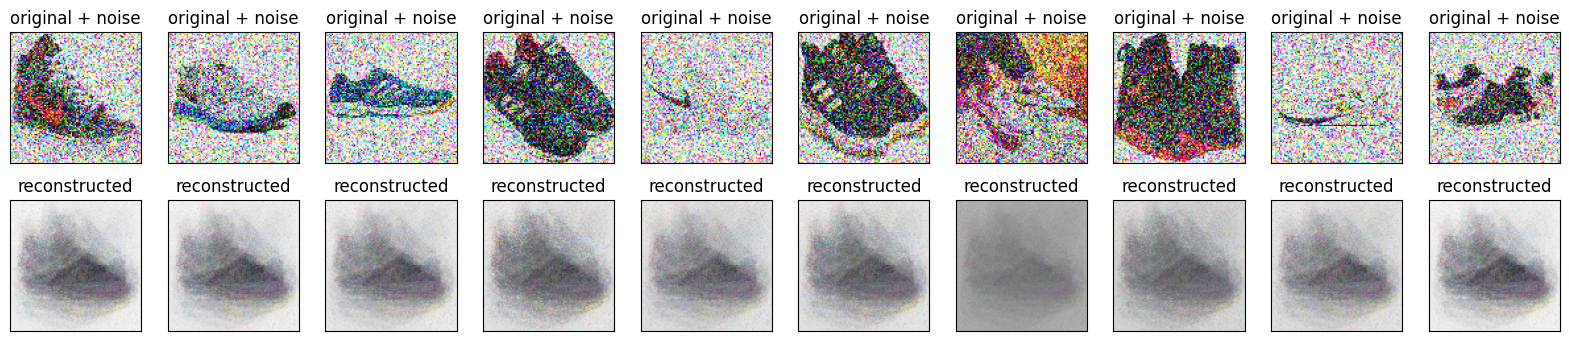

In [16]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

In [12]:
# Perhitungan MSE antara citra asli x_test dan citra rekonstruksi decode_imgs
from sklearn.metrics import mean_squared_error

# Menggunakan model autoencoder untuk melakukan rekonstruksi citra uji
decode_imgs = autoencoder.predict(x_test)

# Menghitung MSE antara citra asli dan citra rekonstruksi
mse = mean_squared_error(x_test.flatten(), decode_imgs.flatten())
print("Mean Squared Error (MSE) antara citra asli dan citra rekonstruksi:", mse)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Mean Squared Error (MSE) antara citra asli dan citra rekonstruksi: 0.091172494


In [13]:
from sklearn.metrics import mean_absolute_error

# Menggunakan model autoencoder untuk melakukan rekonstruksi citra uji
decoded_imgs = autoencoder.predict(x_test)

# Menghitung MAE antara citra asli dan citra rekonstruksi
mae = mean_absolute_error(x_test.flatten(), decoded_imgs.flatten())
print("Mean Absolute Error (MAE) antara citra asli dan citra rekonstruksi:", mae)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Mean Absolute Error (MAE) antara citra asli dan citra rekonstruksi: 0.2519457


In [14]:
import numpy as np
from skimage.metrics import peak_signal_noise_ratio

# Menggunakan model autoencoder untuk melakukan rekonstruksi citra uji
decoded_imgs = autoencoder.predict(x_test)

# Menghitung PSNR antara citra asli dan citra rekonstruksi
psnr = peak_signal_noise_ratio(x_test, decoded_imgs, data_range=1.0)
print("Peak Signal-to-Noise Ratio (PSNR) antara citra asli dan citra rekonstruksi:", psnr)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Peak Signal-to-Noise Ratio (PSNR) antara citra asli dan citra rekonstruksi: 10.401362154084223
